In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pingouin

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Navigation

# fps

In [9]:
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
overview = pd.DataFrame(
    [
        [len(data_trial)],
        [len(data_et)]
    ], 
    index=['data_trial', 'data_et'])
print(overview)

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (34,35,36,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                0
data_trial  43256
data_et     54147


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (42,45,46,47,48,63) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
count = data_et.groupby(['run_id', 'task_nr', 'trial_index'])['x'].count() \
    .reset_index()
count
data_trial.merge(count, on=['run_id', 'trial_index'], how='left')
data_trial['fps_2'] = 1000 * data_trial['count'] / data_trial['trial_duration_exact']
data_trial.loc[
    (data_trial['run_id']==2) & 
    (data_trial['trial_type'].isin(['eyetracking-choice'])),
    ['task_nr', 'trial_index', 'trial_type', 'fps', 'fps_2', 'webcam_label']]

,task_nr,trial_index,trial_type,fps,fps_2,webcam_label
43056,2.0,55.0,eyetracking-choice,10.059613,10.059613,Integrierte iSight-Kamera
43069,2.0,58.0,eyetracking-choice,10.147601,10.147601,Integrierte iSight-Kamera
43084,2.0,62.0,eyetracking-choice,10.265398,10.265398,Integrierte iSight-Kamera
43100,2.0,65.0,eyetracking-choice,10.428737,10.428737,Integrierte iSight-Kamera


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


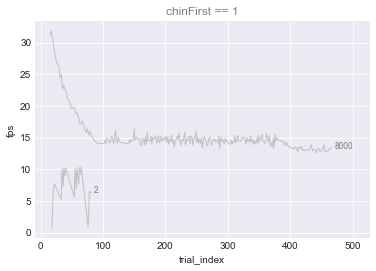

In [27]:
def spaghettiPlot(data, xVar, yVar):
    highlightedSubject = data['run_id'].unique()[0]
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots()

    # Draw Plots
    for subject in data["run_id"].unique():
        df_thisSubject = data[data['run_id']==subject]
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+5, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+5, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial.loc[data_trial['chinFirst']==1 &
                          data_trial['trial_type'].isin(
                              ['eyetracking-calibration', 
                               'eyetracking-fix-object', 
                               'eyetracking-choice']) &
                          ~((data_trial['trial_type']=='eyetracking-fix-object') &
                            (data_trial['task_nr']==3)), 
                          :],
    'trial_index', 
    'fps')
xVar = 'trial_index'
yVar = 'fps'
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel(xVar)
plt.ylabel(yVar)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


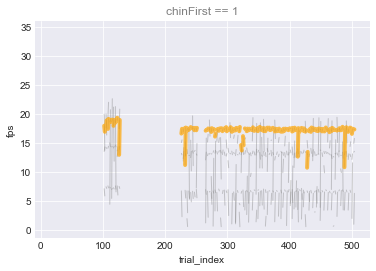

In [28]:
spaghettiPlot(
    data_trial.loc[data_trial['chinFirst']==0 &
                          data_trial['trial_type'].isin(
                              ['eyetracking-calibration', 
                               'eyetracking-fix-object', 
                               'eyetracking-choice']) &
                          ~((data_trial['trial_type']=='eyetracking-fix-object') &
                            (data_trial['task_nr']==3)), 
                          :],
    'trial_index', 
    'fps')
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel(xVar)
plt.ylabel(yVar)
plt.show()

## data_et_fixation

In [2]:
data_et_fixation = pd.read_csv('data_jupyter/data_et_fixation.csv')

def cleanETData(data):
    data = data.loc[
        (
            (data['t_task'] > 1000)
        ),
        :
    ]
    return data

data_et_fixation = cleanETData(data_et_fixation)

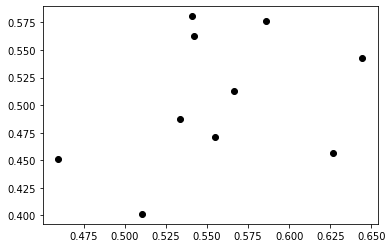

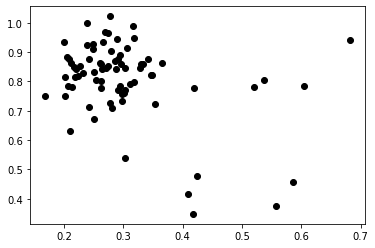

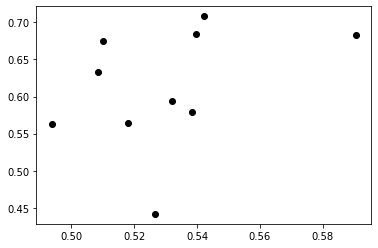

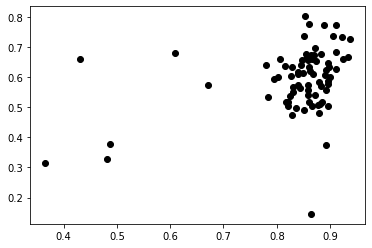

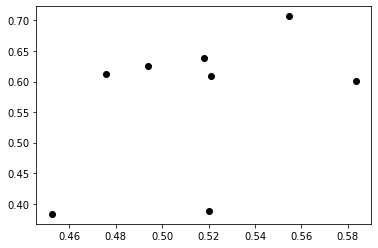

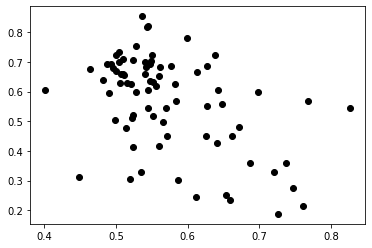

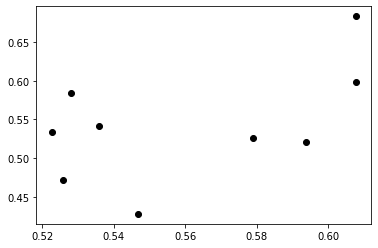

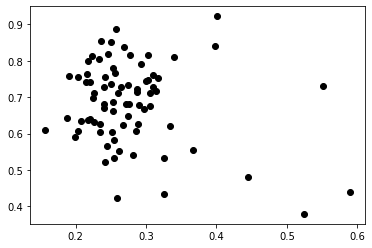

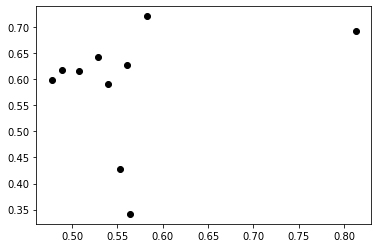

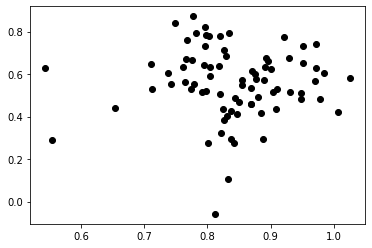

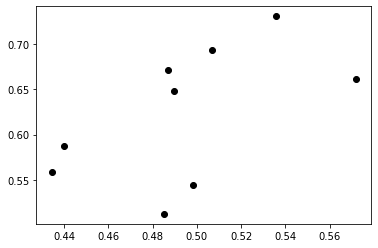

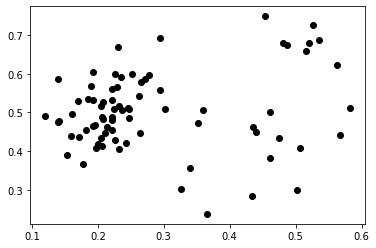

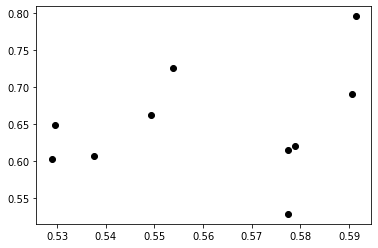

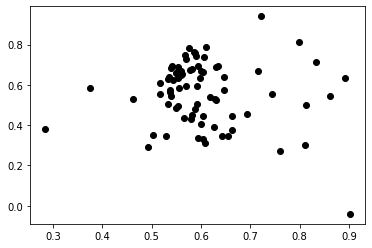

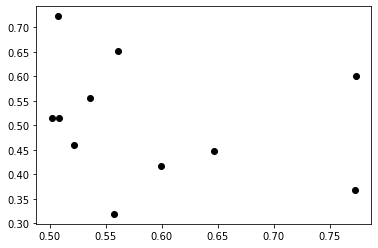

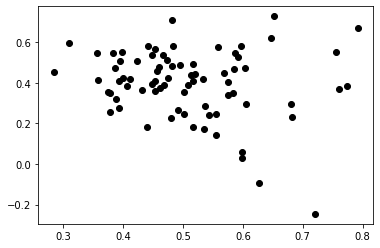

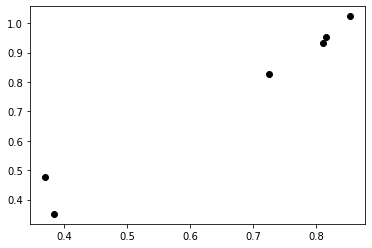

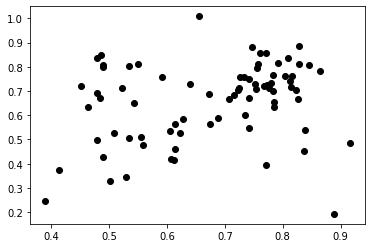

In [19]:
data_et_fixation_noChin = data_et_fixation.loc[data_et_fixation['chin'] == 0]

def plotPerTrial(data):
    for trial in data['withinTaskIndex'].unique():
        x = data.loc[data['withinTaskIndex'] == trial, 'x']
        y = data.loc[data['withinTaskIndex'] == trial, 'y']
        plt.plot(x, y, 'o', color='black')
        plt.show()
        
plotPerTrial(data_et_fixation.loc[data_et_fixation['chin'] == 0])

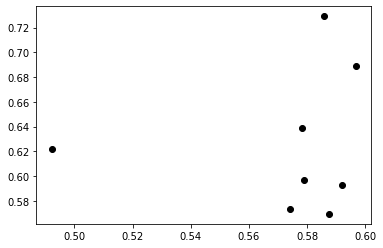

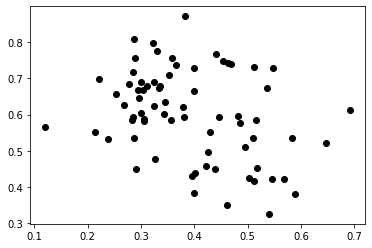

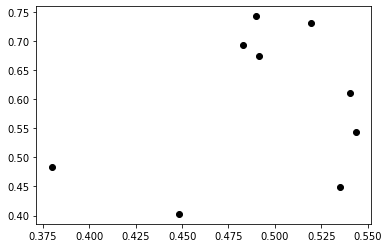

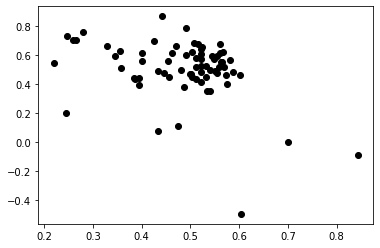

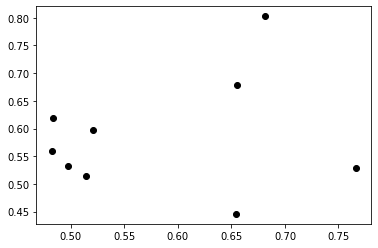

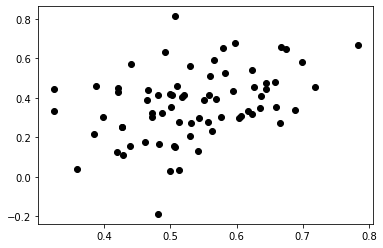

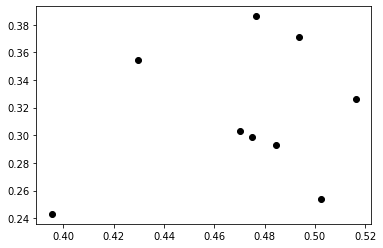

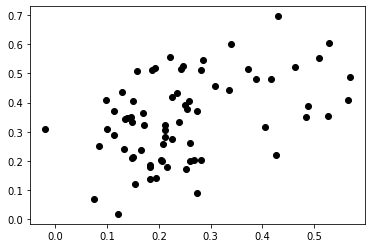

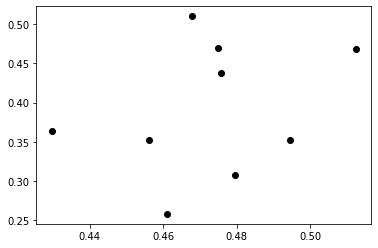

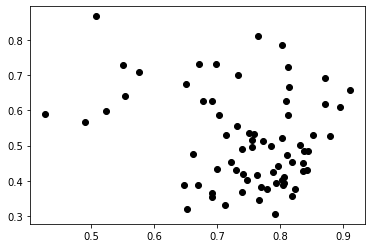

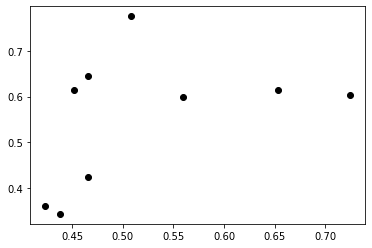

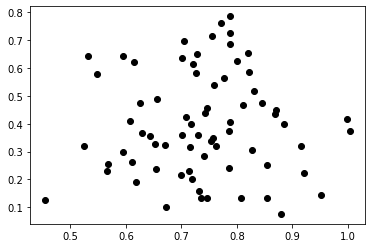

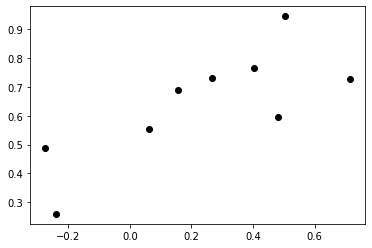

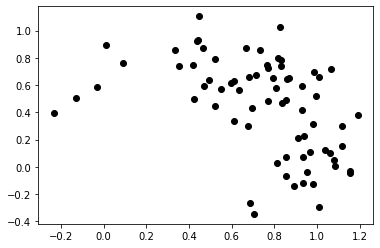

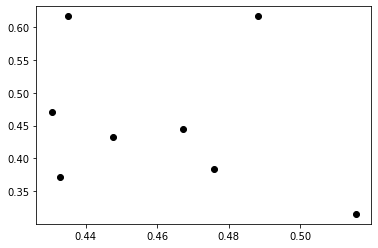

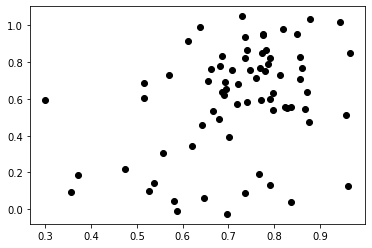

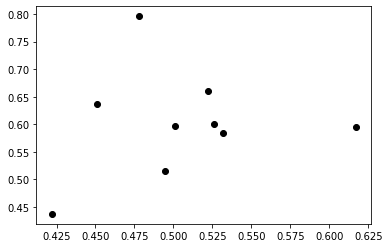

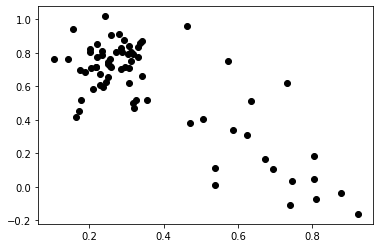

In [20]:
plotPerTrial(data_et_fixation.loc[data_et_fixation['chin'] == 1])

# data_et_choice

In [13]:
data_et_choice = pd.read_csv('data_jupyter/data_et_choice.csv')

def cleanETData(data):
    data = data.loc[
        (
            (data['t_task'] > 1000)
        ),
        :
    ]
    return data

data_et_choice = cleanETData(data_et_choice)

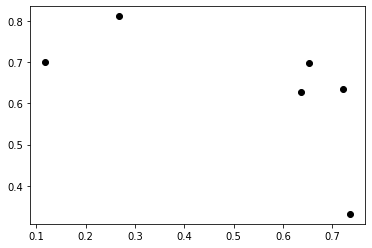

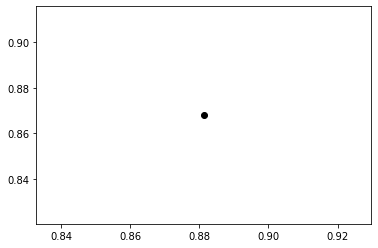

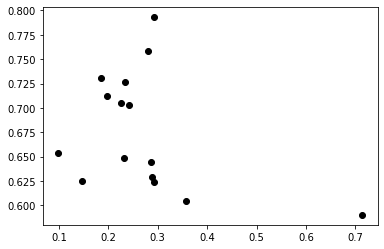

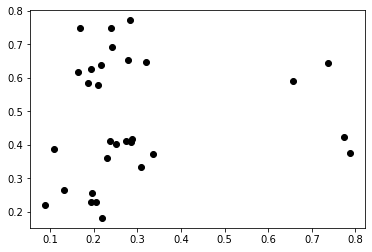

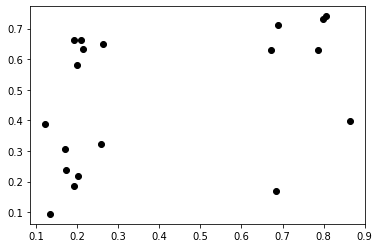

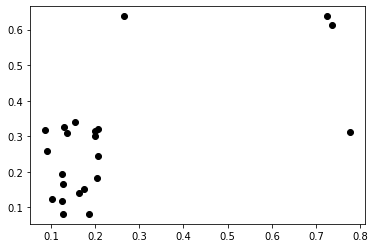

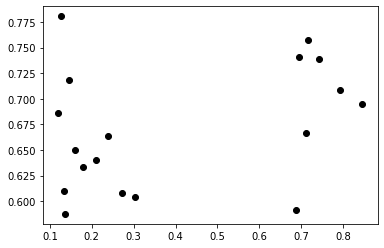

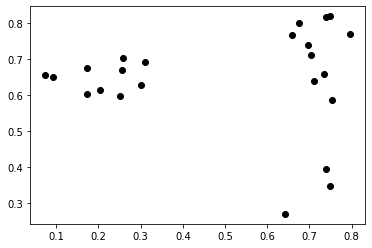

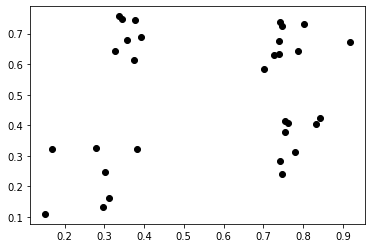

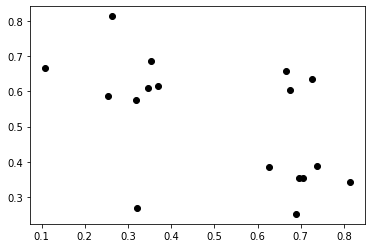

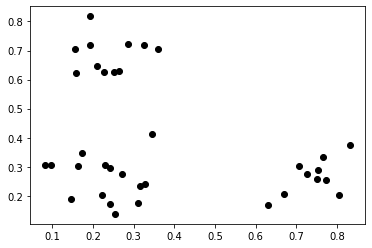

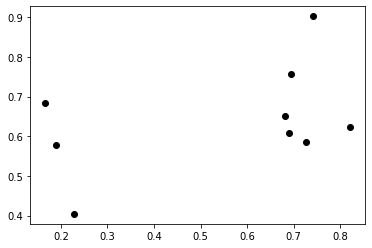

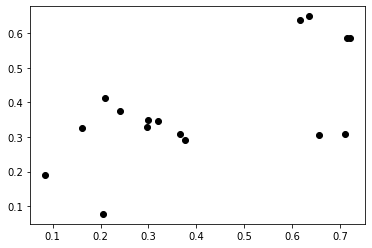

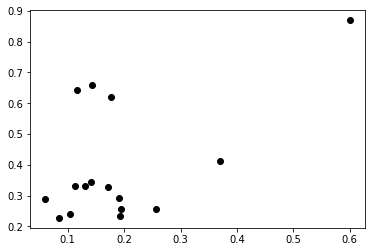

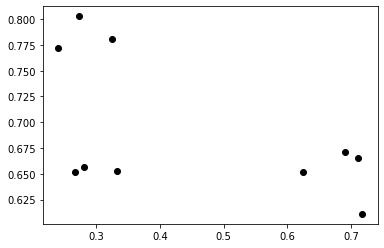

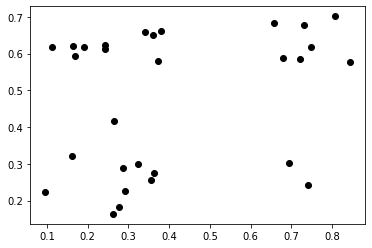

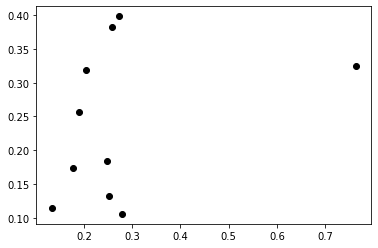

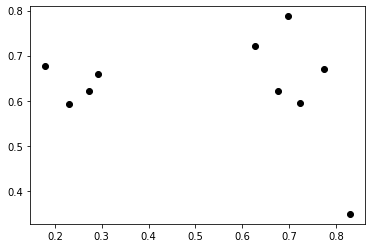

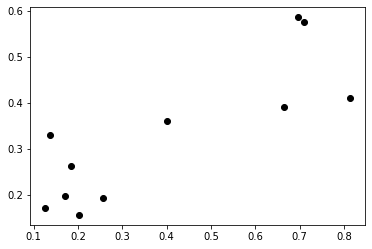

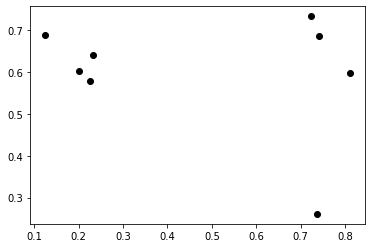

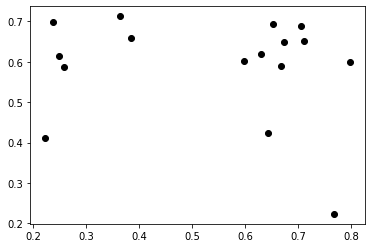

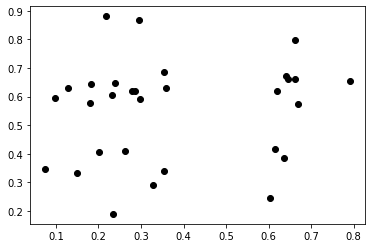

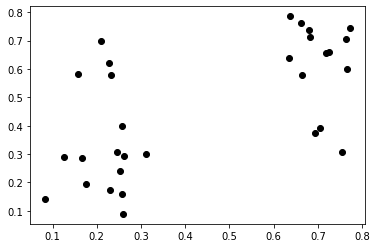

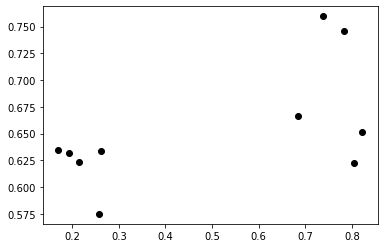

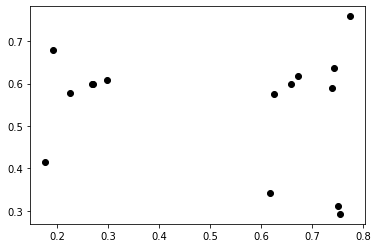

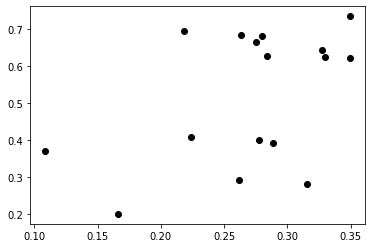

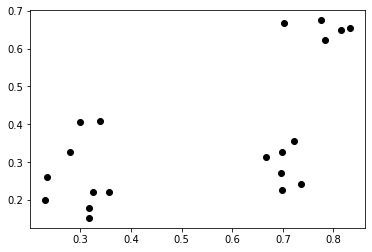

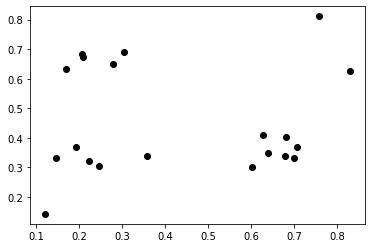

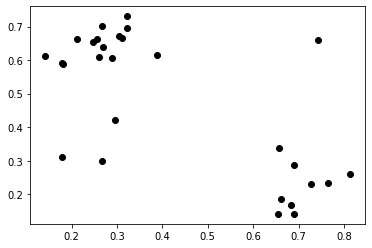

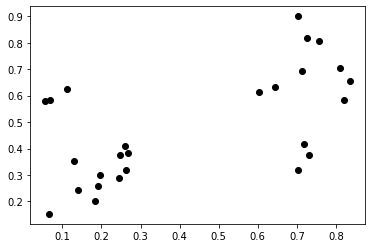

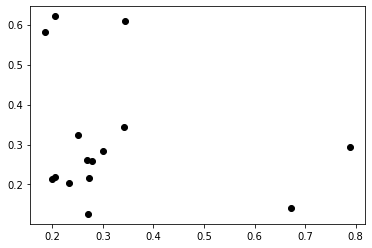

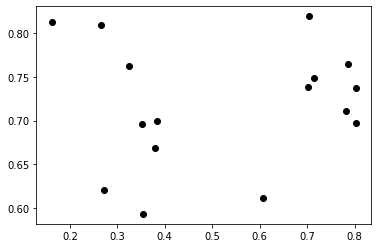

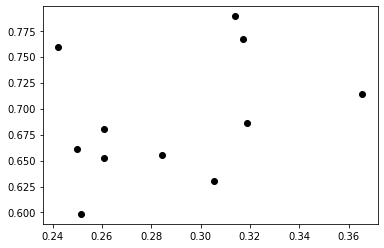

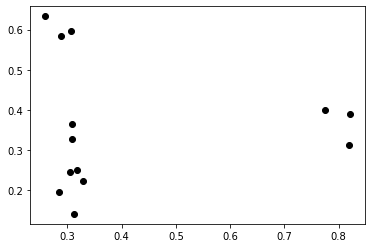

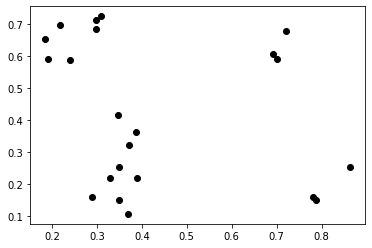

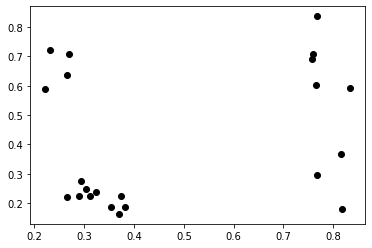

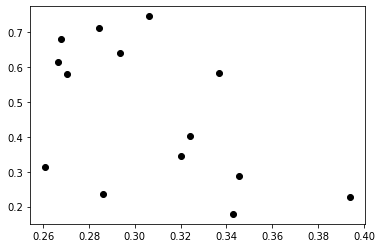

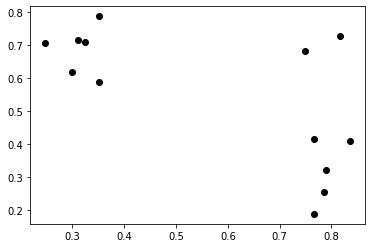

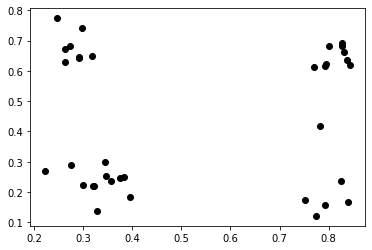

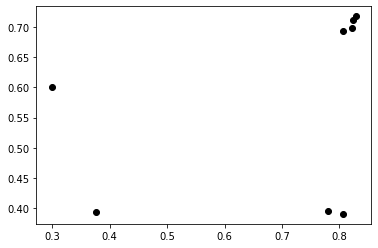

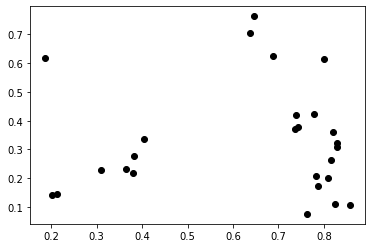

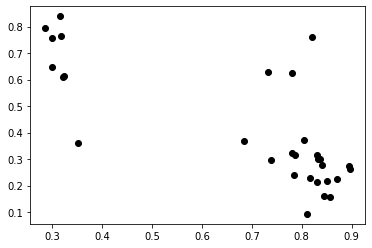

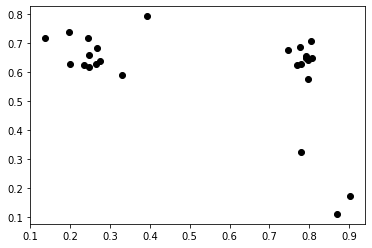

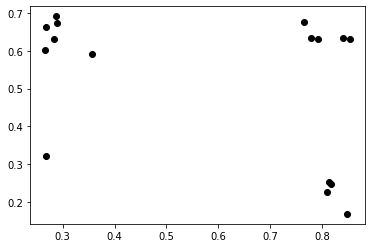

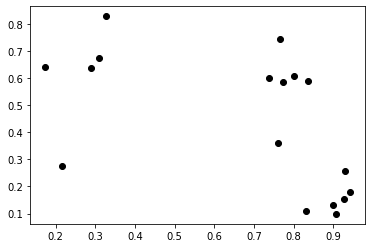

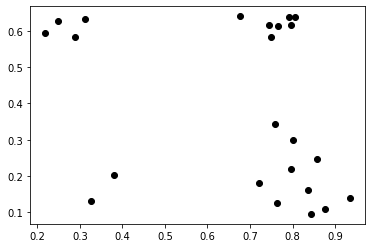

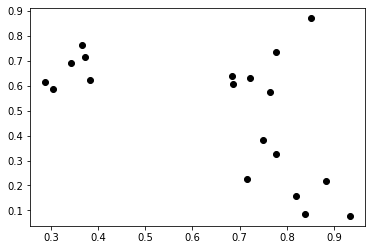

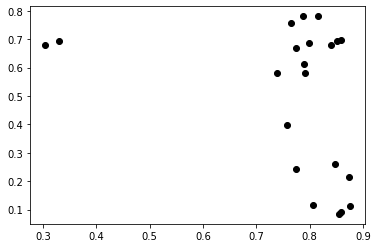

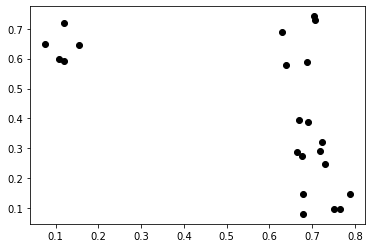

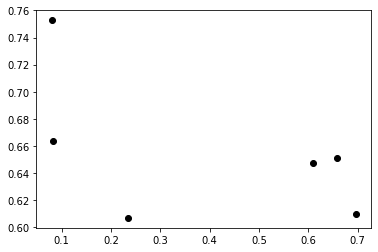

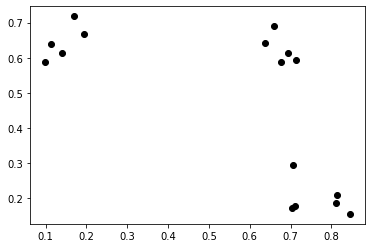

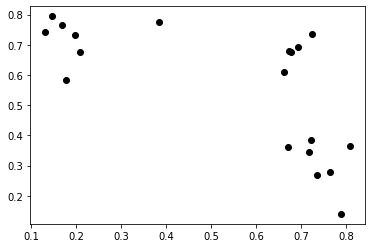

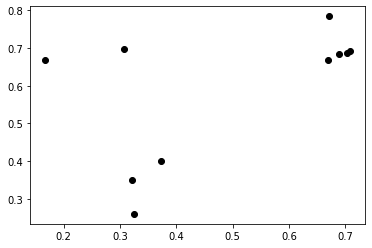

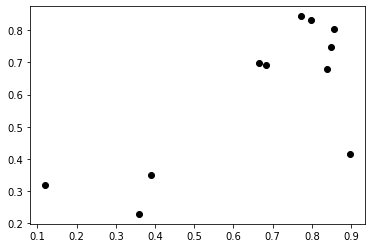

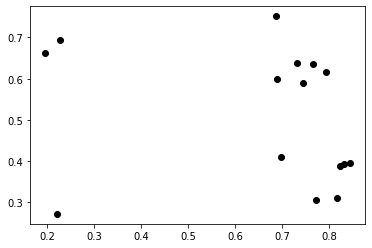

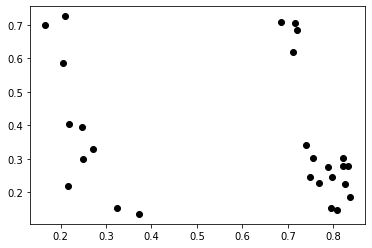

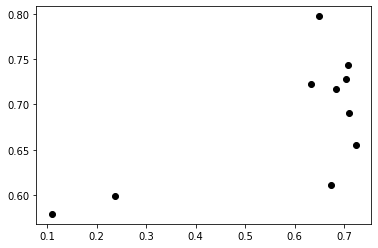

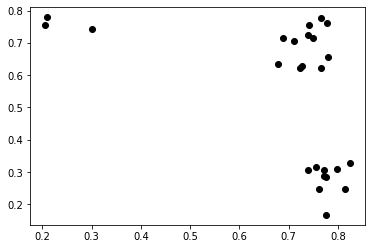

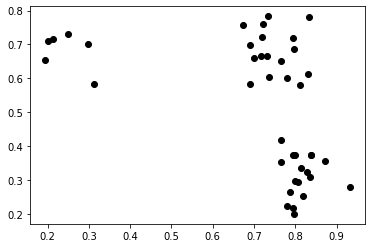

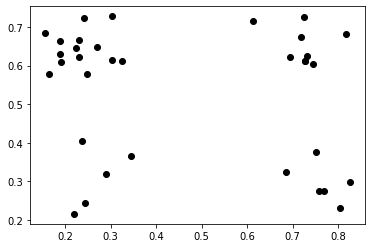

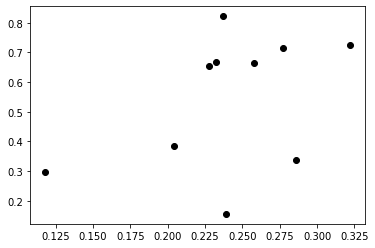

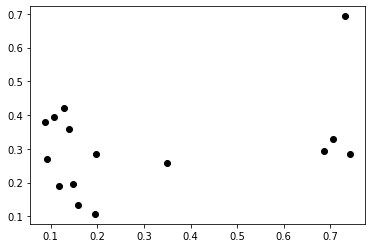

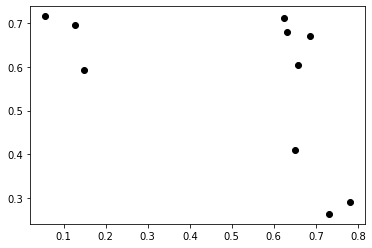

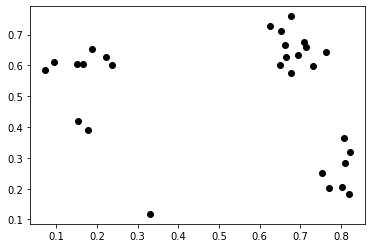

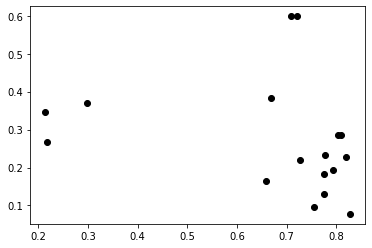

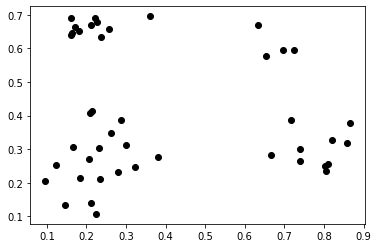

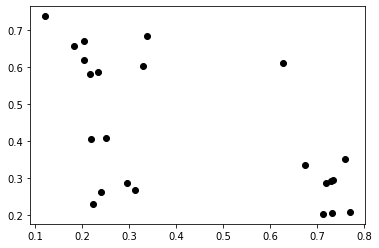

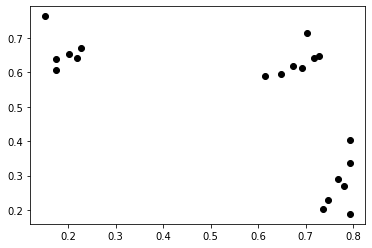

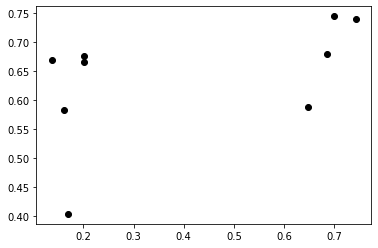

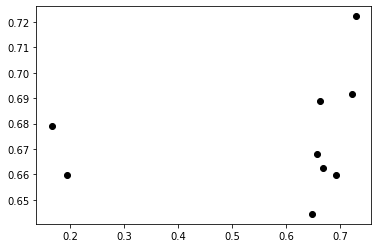

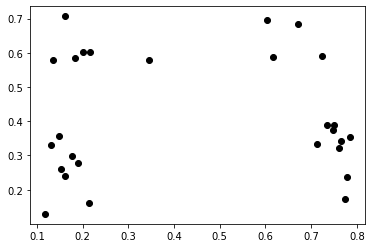

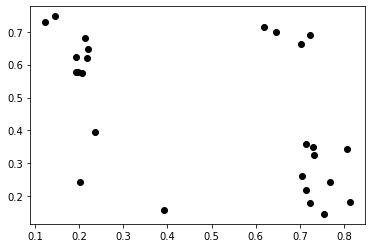

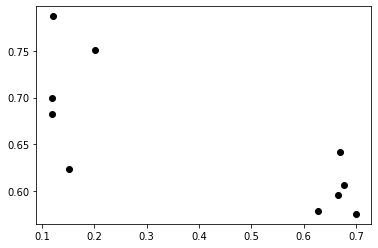

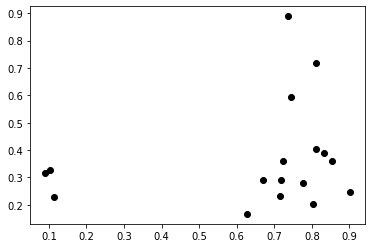

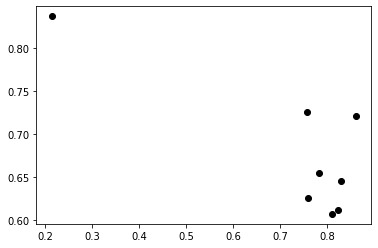

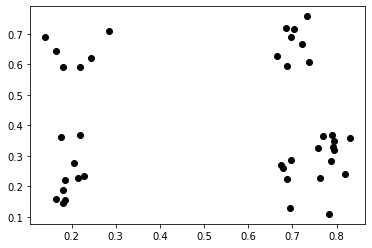

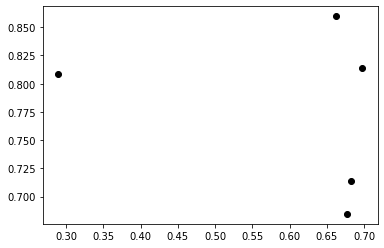

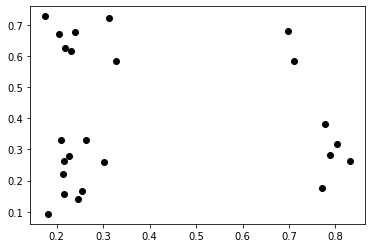

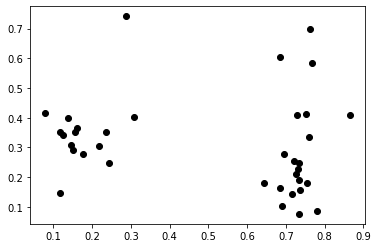

In [21]:
plotPerTrial(data_et_choice)

# Bins

%Outputs: Eye tracking bins with average proportion of looking top for
%each subject over trials when they chose the top option (binsT.csv) or
%the right option (binsB.csv). Also, the proportion of left choice based on
%the last fixation being to the left (looksL.csv) or right (looksR.csv)

cd(strcat(dataPath, '\intermediateCSVs'))
csvwrite('binsT.csv',binsT) 
csvwrite('binsB.csv',binsB)
csvwrite('looksT.csv',looksT)
csvwrite('looksB.csv',looksB)
cd(dataPath)

In [20]:
data_et_choice = pd.read_csv('data_compiled/data_et_choice.csv')
data_trial_choice = pd.read_csv('data_compiled/data_trial_choice.csv')

In [36]:
data_et_choice.columns

Index(['run_id', 'subject', 'chinFirst', 'index', 'trial_index', 'task_nr',
       'option_topLeft', 'option_topRight', 'option_bottomLeft',
       'option_bottomRight', 'x', 'y', 'window_width', 'window_height',
       'window_width_max', 'window_height_max', 't_wg', 't_task', 'key_press',
       'look_left', 'look_top', 'ssOption_top', 'chose_top', 'chose_ssOption',
       'choiceNr', 'aoi', 'aoi_amount_SS', 'aoi_amount_LL', 'aoi_delay_SS',
       'aoi_delay_LL', 'newAOIIndex', 'transition_type'],
      dtype='object')

In [65]:
# for subject in data_et_choice['run_id'].unique():
for trial in [1]: # data_thisSubject['choiceNr'].unique():
    data_thisTrial = data_et_choice.loc[
                                        (
                                            (data_et_choice['run_id']==16) &
                                            (data_thisSubject['choiceNr']==trial)
                                        ), :]  
    nLookTop = len(data_thisTrial.loc[data_thisTrial['y'] < (data_thisTrial['window_height']/2), :])
    probLookTop = nLookTop / len(data_thisTrial)
    print(probLookTop)
#     test = pd.qcut(data_thisTrial.index, q=5)

0.17647058823529413


In [ ]:
binsT = [run_id, avg gaze points left ]

# Prescreeing

[Back to Navigation](#Navigation)

In [58]:
data_raw.loc[(data_raw["success"] != '"'), ["run_id", "trial_index", "success"]]

,run_id,trial_index,success
13,16,13,true
500,16,500,true
516,17,13,true
1003,17,500,true
1019,18,13,true
1506,18,500,true
1522,20,13,true
2009,20,500,true


What trials were completed too quickly?

In [59]:
data_trial["tooQuick"] = ((data_trial["trial_duration_exact"] < 1000) & \
                         (data_trial["trial_type"] != "eyetracking-calibration") & \
                         (data_trial["stimulus"] != '"'))
data_trial.loc[0, "tooQuick"] = False
data_trial.loc[len(data_trial)-1, "tooQuick"] = False
# data_trial[(data_trial["tooQuick"]==True)]

In [60]:
def checkFullscreen(data, XorYVariable):
    index = data.loc[
                (
                    (
                        (data["trial_type"] == 'eyetracking-calibration') |
                        (data["trial_type"] == 'eyetracking-fix-object') |
                        (data["trial_type"] == 'eyetracking-choice') 
                    ) &
                    (data[XorYVariable] != '"') &
                    (data[XorYVariable] != data[XorYVariable + '_max'])
                )
    ].index

    if len(index) > 0:
        print(XorYVariable + ' is not maxed out! Check out the following indices')
        print(index)
    else:
        print(XorYVariable + ' is checked and no variations were found')

checkFullscreen(data_trial, 'window_width')
checkFullscreen(data_trial, 'window_height')

window_width is checked and no variations were found
window_height is checked and no variations were found


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# Hypotheses
[Back to Navigation](#Navigation)

## H1, H2, H4

To answer hypothesis 1, and 4, we will predict the subject’s choices from the intertemporal choice task with a mixed-effects logistic regression, with the option index (H1), the attribute index (H2), the Payne Index (H3), and the trial number as fixed effects and the subject as the random effect. 

### Data Cleaning

In [61]:
# Missing values
## Row-wise
# print(df.isnull().values.sum())
## Column-wise
# print(df.isnull().sum())

In [62]:
data_trial_choice_clean = data_trial_choice \
    .loc[(data_trial_choice['trial_duration_exact']<10000), :]

### Check for Confounders

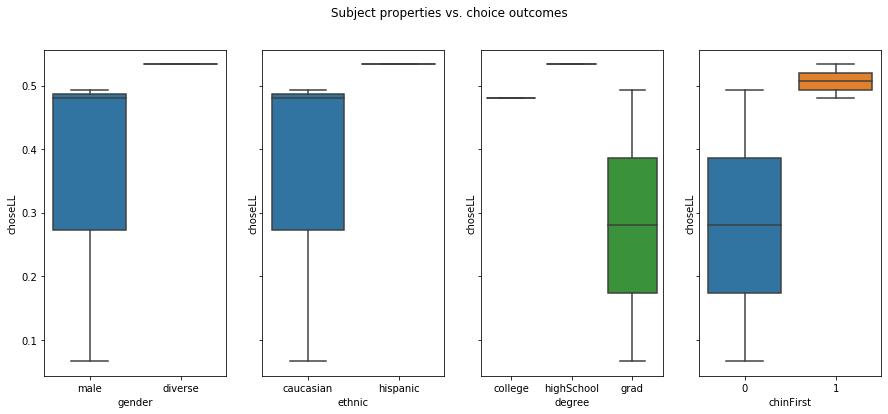

In [63]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
                'gender',
                'ethnic', 
                'degree',
                'chinFirst', 
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='choseLL', data=data_subject)
   
plt.show()

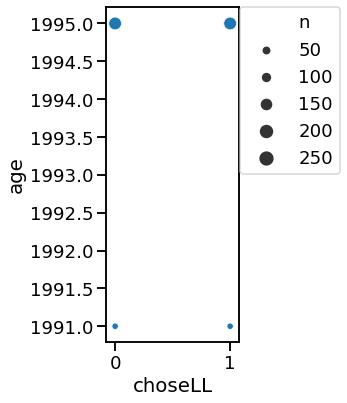

In [136]:
# window_diagonal_max
# age
# choiceNr
def bubblePlot(categorical_variable, distinct_variable, data):
    
    sns.set_context("talk", font_scale=1.1)
    plt.figure(figsize=(5,6))
    
    data_bubblePlot = data.loc[:, [categorical_variable, distinct_variable]]
    grouped = data_bubblePlot.groupby([distinct_variable]) \
        .count() \
        .rename(columns={categorical_variable: 'n'}) \
        .reset_index()
    data_bubblePlot = data_bubblePlot.merge(grouped, 
                                                 on=distinct_variable, 
                                                 how='left')
    data_bubblePlot['n'] = data_bubblePlot['n']     
    
    sns.scatterplot(x=categorical_variable, 
                    y=distinct_variable,
                    size='n',            
                    data=data_bubblePlot)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.xlabel(categorical_variable)
    plt.xticks([0, 1])
    plt.ylabel(distinct_variable)
    plt.tight_layout()
    plt.show()

bubblePlot(categorical_variable = 'choseLL', 
           distinct_variable = 'age', 
           data = data_trial_choice)

### Correlation

In [65]:
correlation_columns = [
                            'trial_duration_exact',
                            'fps',
                            'k', 
                            'choiceNr',
                            'optionIndex',
                            'attributeIndex', 
                            'payneIndex',
                        ]

### Plot

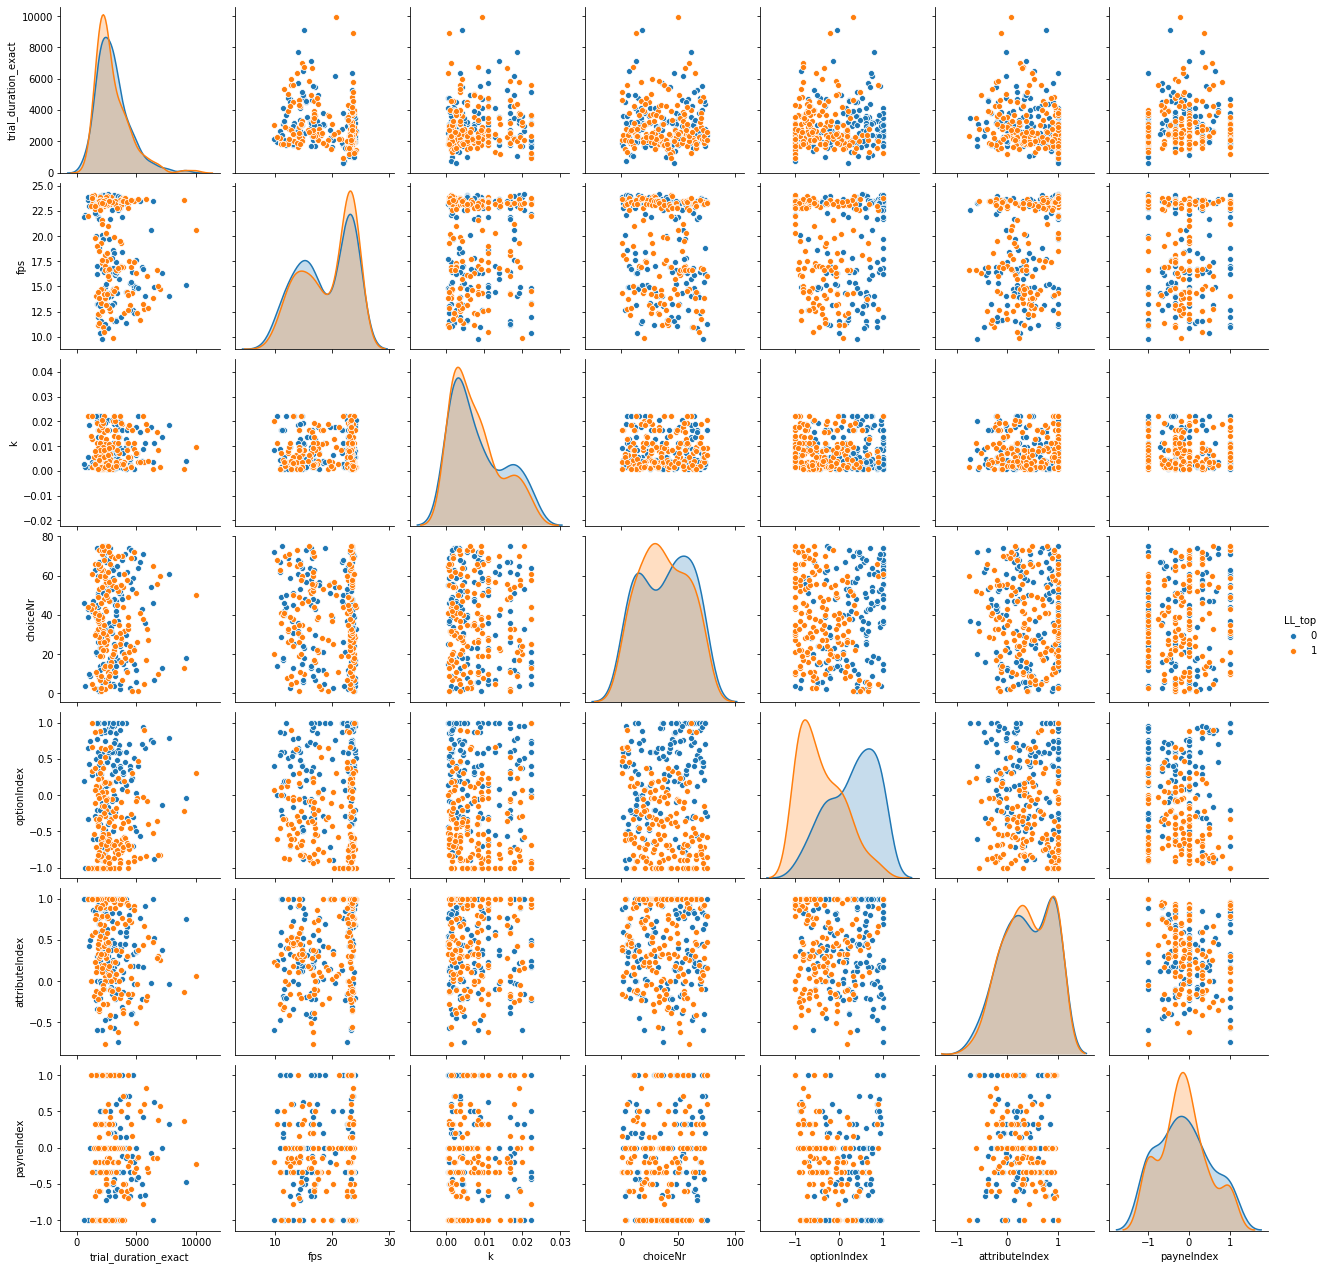

In [66]:
sns.pairplot(data_trial_choice_clean.loc[:,
        np.append(correlation_columns, ['LL_top'])
    ],
    hue='LL_top')

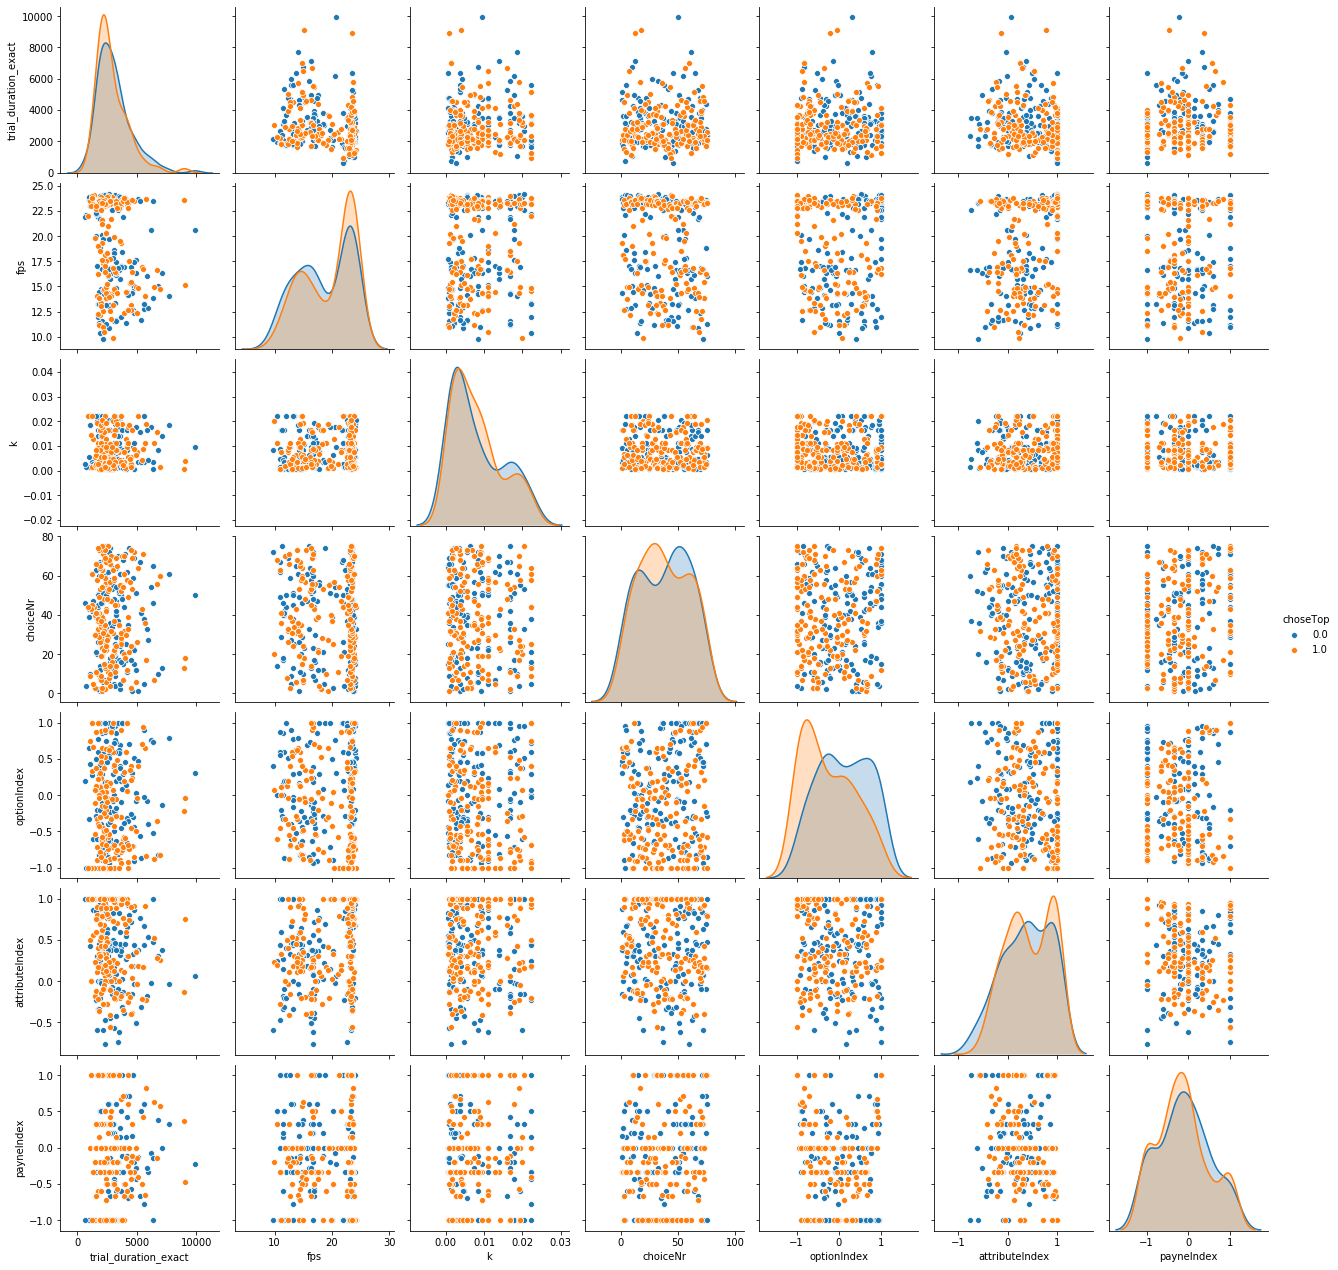

In [67]:
sns.pairplot(data_trial_choice_clean.loc[:,
        np.append(correlation_columns, ['choseTop'])
    ],
    hue='choseTop')

In [1]:
corr_matrix = np.corrcoef(data_trial_choice_clean[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

NameError: name 'np' is not defined

In [69]:
data_trial_choice_clean[correlation_columns].rcorr()

,trial_duration_exact,fps,k,choiceNr,optionIndex,attributeIndex,payneIndex
trial_duration_exact,-,**,,,,**,
fps,-0.189,-,,,,***,
k,0.042,0.093,-,,,,
choiceNr,-0.025,-0.09,-0.063,-,,,**
optionIndex,0.005,-0.064,0.022,0.051,-,,
attributeIndex,-0.166,0.324,0.006,-0.027,-0.06,-,***
payneIndex,0.057,0.006,-0.032,0.162,-0.063,-0.341,-


In [70]:
data_trial_choice_clean[correlation_columns].rcorr(upper='n')

,trial_duration_exact,fps,k,choiceNr,optionIndex,attributeIndex,payneIndex
trial_duration_exact,-,293,293,293,293,293,273
fps,-0.189,-,293,293,293,293,273
k,0.042,0.093,-,293,293,293,273
choiceNr,-0.025,-0.09,-0.063,-,293,293,273
optionIndex,0.005,-0.064,0.022,0.051,-,293,273
attributeIndex,-0.166,0.324,0.006,-0.027,-0.06,-,273
payneIndex,0.057,0.006,-0.032,0.162,-0.063,-0.341,-


### 4.1.1 Requirements

In [71]:
X = data_trial_choice[["run_id", "choiceNr", "optionIndex", 'attributeIndex', 'payneIndex']]
y = 1-data_trial_choice[["choseLL"]]  

In [72]:
def noMissingValues(data):
    null_data = X.loc[X.isnull().any(axis=1), :]
    if len(null_data) > 0:
        print('There are some missing data. Look here: \n \n')
        print(null_data)
        return(False)
    else:
        print('No missing values!')
        return(True)

In [73]:
noMissingValues(X)

There are some missing data. Look here: 
 

     run_id  choiceNr  optionIndex  attributeIndex  payneIndex
86       17      12.0     1.000000        1.000000         NaN
87       17      13.0    -0.904762        0.904762         NaN
101      17      27.0    -1.000000        1.000000         NaN
104      17      30.0    -1.000000        1.000000         NaN
118      17      44.0    -1.000000        1.000000         NaN
130      17      56.0     1.000000        1.000000         NaN
131      17      57.0    -1.000000        1.000000         NaN
136      17      62.0     1.000000        1.000000         NaN
137      17      63.0    -1.000000        1.000000         NaN
138      17      64.0    -1.000000        1.000000         NaN
139      17      65.0     1.000000        1.000000         NaN
140      17      66.0    -1.000000        1.000000         NaN
141      17      67.0     1.000000        1.000000         NaN
142      17      68.0     1.000000        1.000000         NaN
153      18

False

In [74]:
# def excludeNAN(data):
#     index_null_data = data.loc[data.isnull().any(axis=1), :].index
#     data_output = data.drop(index_null_data).reset_index()
#     return(data_output)

### 4.1.2 Model

In [75]:
# log_reg = sm.Logit(y, X, missing='drop').fit() 
# print(log_reg.summary()) 

## H3
[Back to Navigation](#Navigation)

Clustering

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_trial_choice.loc[:, [
                                                                  'trans_type_0',
                                                                  'trans_type_1',
                                                                  'trans_type_2',
                                                                  'trans_type_3',
                                                                  'trans_type_4',
                                                                  'trans_type_6',
                                                                  'trans_type_7',
                                                                 ]
                                                             ]
                                      )

In [ ]:
def clusters(n_clusters):
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(scaled_features)
            
#     https://realpython.com/k-means-clustering-python/
#     print(kmeans.inertia_)
#     print(kmeans.cluster_centers_)
#     print(kmeans.n_iter_)

    return kmeans.labels_

In [ ]:
output = []
for n_cluster in range(2, 5):
    data_trial_choice['cluster' + str(n_cluster)] = clusters(n_cluster)
    X = data_trial_choice[["run_id", "choiceNr", 'cluster' + str(n_cluster)]]
    X_ = sm.add_constant(X)
    y = 1-data_trial_choice[["choseLL"]]  
    log_reg = sm.Logit(y, X_).fit() 
    output.append([n_cluster, log_reg.bic, log_reg.aic]) 

output = pd.DataFrame(output, columns = ['n_clusters', 'BIC', 'AIC']) \
    .set_index('n_clusters')
output

## H5, H6
[Back to Navigation](#Navigation)

For hypotheses 5 and 6, we will use three mixed-effects general linear models to predict accuracy, precision and frame rate with the chin-rest condition, visual aid variables, trial number (fixed effects) and the subject (random-effect). 

Cleaning

### Checking Confounders

In [ ]:
def BoxPlots(criteria):
    predictors = [
                    'chinFirst',    
                    'eyeshadow', 
                    'masquara',
                    'eyeliner',
                    'browliner',
                    'triedChin', 
                    'keptHead',

                    'vertPosition',
                    'browser',
                    'platform',
                    'gender',
                    'ethnic',
                    'degree',
                 ]

    cm = 1/2.54
    fig, axes = plt.subplots(len(predictors), 1, sharey=True, figsize=(10*cm, 10*len(predictors)*cm))
    fig.suptitle('Subject properties vs. choice outcomes')



    for i in range(0, len(predictors)):
        sns.boxplot(ax=axes[i], x=predictors[i], y=criteria, data=data_subject)

    plt.show()

BoxPlots('fps')
# BoxPlots('offset_perc')
# BoxPlots('precision_perc')

t-Test

In [ ]:
def t_test(data, predictor, outcome):
    sample_A = data.loc[
                          data[predictor] == 0,
                          outcome
                       ] \
        .reset_index(drop=True)
    sample_B = data.loc[
                          data[predictor] == 1,
                          outcome
                       ] \
        .reset_index(drop=True)
    t_test = sm.stats.ttest_ind(sample_A, sample_B)
    return t_test

In [ ]:
def t_test_for_criterion(criterion): 
    binaryPredictor = [
                    'chinFirst',
                    'eyeshadow', 
                    'masquara',
                    'eyeliner',
                    'browliner',
                    'triedChin', 
                    'keptHead',
                   ]

    output = []
    for i in range(0, len(binaryPredictor)):
        output.append(
            [
                t_test(data_trial_fixation, binaryPredictor[i], criterion)[0],
                t_test(data_trial_fixation, binaryPredictor[i], criterion)[1],
                t_test(data_trial_fixation, binaryPredictor[i], criterion)[2]
            ]

        )
    output = pd.DataFrame(output, columns=['p_left', 'p_right', 'N']) # For unequal variances: equal_var = False
    return output

t_test_for_criterion('fps')
t_test_for_criterion('offset_perc')
t_test_for_criterion('precision_perc')

### Plot predictors

In [ ]:
sns.pairplot(data_trial_fixation.loc[:, 
                              [
                                  'fixation_nr', 'positionIndex',
                                  'trial_duration_exact',
                                  'fps', 
                                  'run_id'
                              ]
                          ], 
             hue='run_id')

In [ ]:
sns.pairplot(data_trial_fixation.loc[:, 
                              [
                                  'age', 
                                  'fixation_nr', 'positionIndex',
                                  'trial_duration_exact',
                                  'fps',
                                  'chin'
                              ]
                          ], 
             hue='chin')

### Correlation

In [ ]:
df_correlation = data_trial_fixation.loc[:, [
    'task_nr', 'chinFirst',  'positionIndex', 'fixation_nr',
    'age', 
    'chin', 
    'fps', 'offset_perc', 'precision_perc'
       ]]
df_correlation.dtypes

In [ ]:
corr_matrix = np.corrcoef(df_correlation.T)
smg.plot_corr(corr_matrix, xnames=df_correlation.columns)
plt.show()

In [ ]:
df_correlation.rcorr()

In [ ]:
df_correlation.rcorr(upper='n')

### Model

In [ ]:
data_trial_fixation.to_csv("data_trial_fixation.csv", index=False, header=True)

In [ ]:
# model = smf.mixedlm("offset_perc ~ chin", data_h5h6, groups=data_h5h6["subject"])
# model_fit = model.fit()
# print(model_fit.summary())

# Exploratory Analysis

[Back to Navigation](#Navigation)

## Does the accuracy improve during calibration?

In [ ]:
def spaghettiPlot(data, myTitle, thisColumn, highlightedSubject):
    df_highlightedSubject = data[(data['run_id']==highlightedSubject)].reset_index()
    maxIndex = df_highlightedSubject.index.max()
    plt.style.use('seaborn-darkgrid')

    fig, ax = plt.subplots()

    # Draw Plots
    for subject in data["run_id"].unique():
        df_thisSubject = data[(data['run_id']==subject)].reset_index()
        ax.plot(df_thisSubject.index, 
                 df_thisSubject[thisColumn], 
                 marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(df_highlightedSubject.index, 
            df_highlightedSubject[thisColumn], 
            marker='', color='orange', linewidth=4, alpha=0.7)
    ax.set_ylim(0,100)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            df_thisSubject = data[(data['run_id']==subject)]
            ax.text(maxIndex + 5, 
                    df_thisSubject[thisColumn].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

    # And add a special annotation for the group we are interested in
    ax.text(maxIndex + 5, 
            df_highlightedSubject[thisColumn].tail(1), 
            highlightedSubject, 
            horizontalalignment='left', size='medium', color='orange')

    plt.title(myTitle, loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Trial-Index")
    plt.ylabel(thisColumn)
    plt.show()

Ceil deviation to window_height_max

Plot deviation over calibration trials

In [ ]:
data_et_calibration_1 = data_et_calibration \
    .loc[(
            (
                (data_et_calibration['chinFirst']==0) &
                (data_et_calibration['chin']==0)
            ) |
            (
                (data_et_calibration['chinFirst']==1) &
                (data_et_calibration['chin']==1)
            )
         ), 
            [
                "run_id", "index", "offset_perc"
            ]
        ] \
    .groupby(["run_id", "index"]).mean() \
    .reset_index() 
# data_et_calibration_1.run_id.unique()
spaghettiPlot(data_et_calibration_1, "First calibration - deviation over trials", "offset_perc", 20)

In [ ]:
data_et_calibration_2 = data_et_calibration \
    .loc[(
            (
                (data_et_calibration['chinFirst']==0) &
                (data_et_calibration['chin']==1)
            ) |
            (
                (data_et_calibration['chinFirst']==1) &
                (data_et_calibration['chin']==0)
            )
         ), 
            [
                "run_id", "index", "offset_perc"
            ]
        ] \
    .groupby(["run_id", "index"]).mean() \
    .reset_index() 
# data_et_calibration_1.run_id.unique()
spaghettiPlot(data_et_calibration_2, "First calibration - deviation over trials", "offset_perc", 20)

[Back to Navigation](#Navigation)